<h1 align="center">Rainfall Predict with LSTM and LSTM Attention </h1>



In [1]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 55.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


Import the library needed

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Attention, Add, Concatenate, Input, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.regularizers import l2
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import sklearn
import seaborn as sns

In [3]:
print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("TensorFlow version:", tf.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)

Pandas version: 2.0.3
NumPy version: 1.25.2
Scikit-learn version: 1.5.0
TensorFlow version: 2.15.0
Matplotlib version: 3.7.1
Seaborn version: 0.13.1


Read data

In [7]:
# Membaca data keseluruhan

#Skenario 1
# rainfall_data_url = "https://raw.githubusercontent.com/arifian853/rainfall-predict-lstm-attention/master/dataset/filled/scenario3/final/final-data-2019-2023.csv"

# Skenario 2
# rainfall_data_url = "https://raw.githubusercontent.com/arifian853/rainfall-predict-lstm-attention/master/dataset/filled/scenario3/final/final-data-2014-2024.csv"

# Skenario 3
# rainfall_data_url = "https://raw.githubusercontent.com/arifian853/rainfall-predict-lstm-attention/master/dataset/filled/scenario3/final/final-data-2013-2024.csv"

# # Skenario 4
rainfall_data_url = "https://raw.githubusercontent.com/arifian853/rainfall-predict-lstm-attention/master/dataset/filled/scenario3/final/final-data-2010-2024.csv"

# # Skenario 5
# rainfall_data_url =
# # Skenario 6
# rainfall_data_url =

df = pd.read_csv(rainfall_data_url, parse_dates=['Tanggal'], index_col='Tanggal')

print('Dataset : \n', df.head())
print('Dataset : \n', df.tail())
print('\n')

# Menghitung jumlah hari dalam dataset
days_count = len(df.index)
print("Jumlah hari dalam dataset:", days_count)




Dataset : 
               Tn    Tx  Tavg  RH_avg   RR   ss  ff_x  ddd_x  ff_avg ddd_car
Tanggal                                                                    
01-01-2010  25.0  31.4  27.1    85.0  0.0  7.3   6.0   45.0     2.0      NE
02-01-2010  25.0  30.8  26.9    86.0  0.0  5.4   5.0   45.0     2.0      NE
03-01-2010  24.0  31.2  27.4    86.0  0.0  4.0   7.0   45.0     3.0      E 
04-01-2010  24.0  27.8  25.9    85.0  0.0  0.0   4.0  270.0     2.0      W 
05-01-2010  25.0  31.0  27.0    84.0  0.0  4.4   6.0   90.0     3.0      NE
Dataset : 
               Tn    Tx  Tavg  RH_avg    RR   ss  ff_x  ddd_x  ff_avg ddd_car
Tanggal                                                                     
27-05-2024  26.6  33.4  29.7    82.0   0.0  1.8   5.0  140.0     2.0      S 
28-05-2024  27.7  33.4  29.0    87.0   0.0  2.7   5.0  170.0     2.0      S 
29-05-2024  25.7  34.0  29.3    83.0  20.6  2.8   5.0  200.0     2.0      C 
30-05-2024  26.9  31.2  28.3    85.0  20.6  6.1   7.0  210.

Correlation matrix


 Correlation Matrix 



<Axes: >

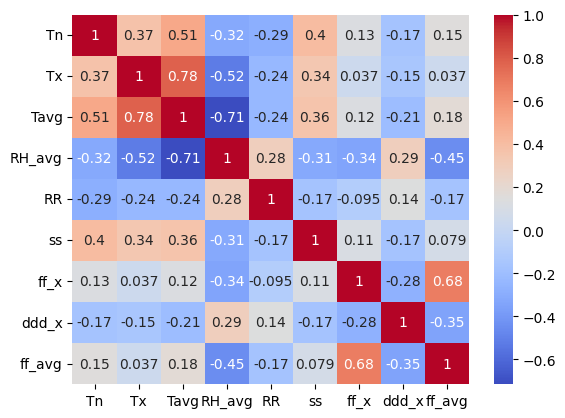

In [5]:
print("\n Correlation Matrix \n")

matrix = df.drop(columns=['ddd_car']).corr()
# matrix = df.corr()
#plotting correlation matrix
sns.heatmap(matrix, cmap="coolwarm", annot=True)


Split data to train, test, and validate

In [10]:
# Membagi data menjadi training, validation, dan testing sets

# Scenario 1 - 70:15:15
# train = df['01-01-2019':'28-02-2022']
# validation = df['01-03-2022':'28-02-2023']
# test = df['01-03-2023':'31-12-2023']

# Scenario 2 - 70:15:15
# train = df['01/01/2014':'15/04/2021']
# validation = df['16/04/2021':'06/11/2022']
# test = df['07/11/2022':'31/05/2024']

# Scenario 2 - 80:10:10
# train = df['01/01/2014':'01/05/2022']
# validation = df['02/05/2022':'16/05/2023']
# test = df['17/05/2023':'31/05/2024']

# # Scenario 3 - 70:15:15
# train = df['01-01-2013':'15-04-2020']
# validation = df['16-04-2020':'05-11-2021']
# test = df['06-11-2021':'31-05-2024']

# Scenario 3 - 80:10:10
# train = df['01-01-2013':'30-04-2021']
# validation = df['01-05-2021':'14-12-2022']
# test = df['15-12-2022':'31-05-2024']

# # Scenario 4 - 70:15:15
# train = df['01-01-2010': '02-02-2020']
# validation = df['03-02-2020' : '01-04-2022']
# test = df['02-04-2022' : '31-05-2024']

# # # Scenario 4 - 80:10:10
train = df['01-01-2010': '13-07-2021']
validation = df['14-07-2021' : '21-12-2022']
test = df['22-12-2022' : '31-05-2024']

# Displaying the number of records in each set
print(f'Training set: {train.shape[0]} records')
print(f'Validation set: {validation.shape[0]} records')
print(f'Test set: {test.shape[0]} records')

# Selecting features and target
features = ['Tavg', 'RH_avg', 'ss', 'ff_avg']
X_train = train[features]
y_train = train['RR']
X_val = validation[features]
y_val = validation['RR']
X_test = test[features]
y_test = test['RR']

Training set: 4212 records
Validation set: 526 records
Test set: 527 records


Normalization and convert to sequence the data

In [13]:
# Normalisasi data
scaler = MinMaxScaler()

# Fit and transform on training set, transform on validation and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Fungsi untuk membentuk data menjadi sequence
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10  # Misalnya, gunakan 10 hari sebelumnya untuk memprediksi hari berikutnya
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val.values, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, time_steps)


Scaled X_train: 
 [[0.55263158 0.58823529 0.64035088 0.25      ]
 [0.52631579 0.61764706 0.47368421 0.25      ]
 [0.59210526 0.61764706 0.35087719 0.375     ]
 ...
 [0.44736842 0.70588235 0.60526316 0.25      ]
 [0.53947368 0.58823529 0.07017544 0.375     ]
 [0.28947368 0.73529412 0.48245614 0.5       ]]
Scaled X_val: 
 [[0.46052632 0.58823529 0.         0.125     ]
 [0.59210526 0.55882353 0.         0.25      ]
 [0.78947368 0.47058824 0.80701754 0.375     ]
 ...
 [0.38157895 0.73529412 0.38596491 0.375     ]
 [0.52631579 0.61764706 0.21929825 0.375     ]
 [0.55263158 0.61764706 0.6754386  0.375     ]]
Scaled X_test: 
 [[0.42105263 0.61764706 0.65789474 0.5       ]
 [0.44736842 0.55882353 0.07894737 0.375     ]
 [0.60526316 0.23529412 0.0877193  0.625     ]
 ...
 [0.84210526 0.52941176 0.24561404 0.25      ]
 [0.71052632 0.58823529 0.53508772 0.25      ]
 [0.69736842 0.61764706 0.53508772 0.25      ]]
y_train: 
 [ 0.   0.   0.  ... 22.5 22.5 22.5]
y_val: 
 [6.000e+00 0.000e+00 0.000e+0

Data shape verification

In [14]:
# Verifikasi bentuk data
print("Shape of X_train_seq:", X_train_seq.shape)
print("Shape of y_train_seq:", y_train_seq.shape)
print("Shape of X_val_seq:", X_val_seq.shape)
print("Shape of y_val_seq:", y_val_seq.shape)
print("Shape of X_test_seq:", X_test_seq.shape)
print("Shape of y_test_seq:", y_test_seq.shape)

Shape of X_train_seq: (4202, 10, 4)
Shape of y_train_seq: (4202,)
Shape of X_val_seq: (516, 10, 4)
Shape of y_val_seq: (516,)
Shape of X_test_seq: (517, 10, 4)
Shape of y_test_seq: (517,)


Minimum value of y_train: 0.0
Maximum value of y_train: 279.5
Minimum value of X_train: Tavg      22.9
RH_avg    65.0
ss         0.0
ff_avg     0.0
dtype: float64
Maximum value of X_train: Tavg      30.5
RH_avg    99.0
ss        11.4
ff_avg     8.0
dtype: float64
Minimum value of y_val: 0.0
Maximum value of y_val: 123.1
Minimum value of X_val: Tavg      24.1
RH_avg    72.0
ss         0.0
ff_avg     1.0
dtype: float64
Maximum value of X_val: Tavg      30.0
RH_avg    97.0
ss        10.9
ff_avg     6.0
dtype: float64
Minimum value of y_test: 0.0
Maximum value of y_test: 298.4
Minimum value of X_test: Tavg      23.8
RH_avg    69.0
ss         0.0
ff_avg     1.0
dtype: float64
Maximum value of X_test: Tavg      30.8
RH_avg    98.0
ss        11.5
ff_avg     6.0
dtype: float64


Regular LSTM model build and training

In [15]:
# Membangun model LSTM biasa
def build_lstm_model(input_shape, units=64, learning_rate=0.01, l2_lambda=0.01, dropout_rate=0.1):
    model = Sequential()
    model.add(LSTM(units, activation='tanh', input_shape=input_shape, kernel_regularizer=l2(l2_lambda), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units, activation='tanh', kernel_regularizer=l2(l2_lambda)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Membangun model LSTM
input_shape = (time_steps, X_train_seq.shape[2])
model_lstm = build_lstm_model(input_shape)

# Displaying model summary
model_lstm.summary()

history_lstm = model_lstm.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, verbose=2, validation_data=(X_val_seq, y_val_seq))

# Evaluasi model LSTM
y_pred_lstm = model_lstm.predict(X_test_seq)

# Denormalize the predictions and ground truth
def denormalize(data, min_value, max_value):
    return data * (max_value - min_value) + min_value

def mean_squared_error(y_true, y_pred):
    n = len(y_true)
    mse = sum((y_true[i] - y_pred[i]) ** 2 for i in range(n)) / n
    return mse

def mean_absolute_error(y_true, y_pred):
    n = len(y_true)
    mae = sum(abs(y_true[i] - y_pred[i]) for i in range(n)) / n
    return mae

def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    return rmse

def r2_score(y_true, y_pred):
    mean_y_true = sum(y_true) / len(y_true)
    ss_tot = sum((y - mean_y_true) ** 2 for y in y_true)
    ss_res = sum((y_true[i] - y_pred[i]) ** 2 for i in range(len(y_true)))
    r2 = 1 - (ss_res / ss_tot)
    return r2

mse_lstm = mean_squared_error(y_test_seq, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test_seq, y_pred_lstm)
rmse_lstm = root_mean_squared_error(y_test_seq, y_pred_lstm)
r2_lstm = r2_score(y_test_seq, y_pred_lstm)

print(" \n ===================================================== \n")
print(f'R-squared LSTM: {r2_lstm}')
print(f'MSE LSTM: {mse_lstm}')
print(f'MAE LSTM: {mae_lstm}')
print(f'RMSE LSTM: {rmse_lstm}')
print(" \n ===================================================== \n")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            17664     
                                                                 
 dropout (Dropout)           (None, 10, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 50753 (198.25 KB)
Trainable params: 50753 (198.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
132/132

LSTM Attention Mechanism model build and training

In [16]:
# Fungsi untuk membuat model LSTM dengan Attention Mechanism
def build_lstm_attention_model(input_shape, lstm_units=64, learning_rate=0.01, l2_lambda=0.01, dropout_rate=0.1):
      inputs = Input(shape=input_shape)

      lstm_out = LSTM(lstm_units, return_sequences=True)(inputs)
      lstm_out = Dropout(dropout_rate)(lstm_out)

      attention = Attention()([lstm_out, lstm_out])
      context_vector = Add()([lstm_out, attention])

      context_vector = LSTM(lstm_units, activation='tanh')(context_vector)
      context_vector = Dropout(dropout_rate)(context_vector)

      outputs = Dense(1)(context_vector)
      model = Model(inputs, outputs)
      optimizer = Adam(learning_rate=learning_rate)
      model.compile(optimizer=optimizer, loss='mse')

      return model

# Membangun model LSTM dengan Attention Mechanism
input_shape = (time_steps, X_train_seq.shape[2])
model_lstm_attention = build_lstm_attention_model(input_shape)

# Displaying model summary
model_lstm_attention.summary()

history_lstm_attention = model_lstm_attention.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32 ,verbose=2, validation_data=(X_val_seq, y_val_seq))

# Evaluasi model LSTM dengan Attention Mechanism
y_pred_lstm_attention = model_lstm_attention.predict(X_test_seq)

def mean_squared_error(y_true, y_pred):
    n = len(y_true)
    mse = sum((y_true[i] - y_pred[i]) ** 2 for i in range(n)) / n
    return mse

def mean_absolute_error(y_true, y_pred):
    n = len(y_true)
    mae = sum(abs(y_true[i] - y_pred[i]) for i in range(n)) / n
    return mae

def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    return rmse

def r2_score(y_true, y_pred):
    mean_y_true = sum(y_true) / len(y_true)
    ss_tot = sum((y - mean_y_true) ** 2 for y in y_true)
    ss_res = sum((y_true[i] - y_pred[i]) ** 2 for i in range(len(y_true)))
    r2 = 1 - (ss_res / ss_tot)
    return r2

mse_lstm_attention = mean_squared_error(y_test_seq, y_pred_lstm_attention)
mae_lstm_attention = mean_absolute_error(y_test_seq, y_pred_lstm_attention)
rmse_lstm_attention = root_mean_squared_error(y_test_seq, y_pred_lstm_attention)
r2_lstm_attention = r2_score(y_test_seq, y_pred_lstm_attention)

print(" \n ===================================================== \n")
print(f'R-squared LSTM with Attention: {r2_lstm_attention}')
print(f'MSE LSTM with Attention: {mse_lstm_attention}')
print(f'MAE LSTM with Attention: {mae_lstm_attention}')
print(f'RMSE LSTM with Attention: {rmse_lstm_attention}')
print(" \n ===================================================== \n")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10, 4)]              0         []                            
                                                                                                  
 lstm_2 (LSTM)               (None, 10, 64)               17664     ['input_1[0][0]']             
                                                                                                  
 dropout_2 (Dropout)         (None, 10, 64)               0         ['lstm_2[0][0]']              
                                                                                                  
 attention (Attention)       (None, 10, 64)               0         ['dropout_2[0][0]',           
                                                                     'dropout_2[0][0]']       

Result and evaluation

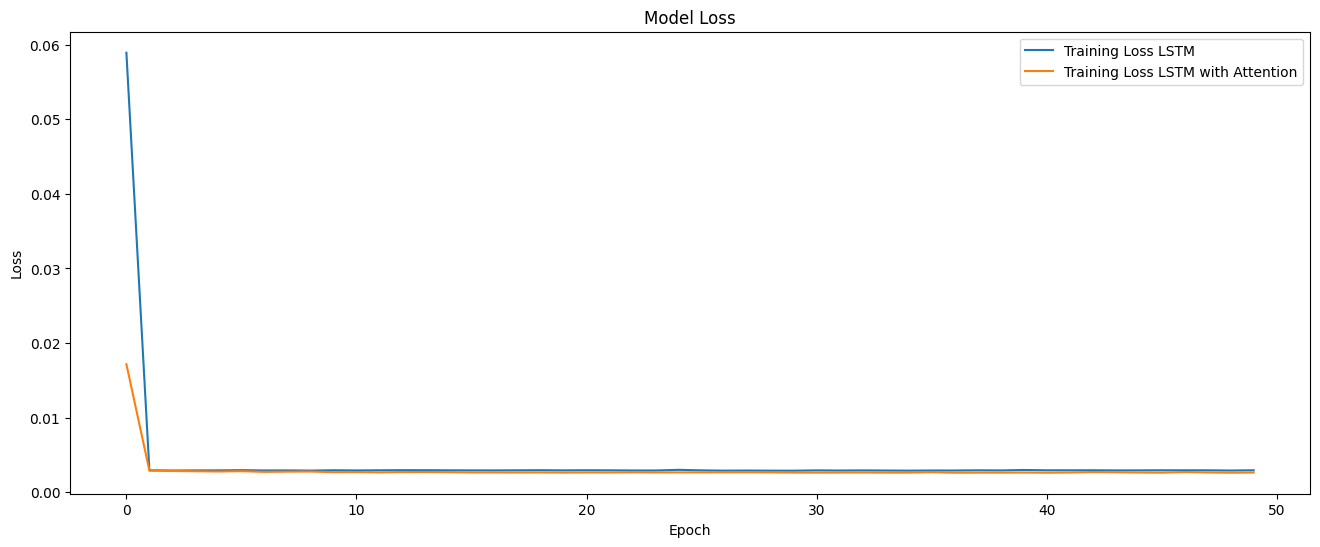

R-squared LSTM: [-0.01811242]
MSE LSTM: [0.00483063]
MAE LSTM: [0.03816532]
RMSE LSTM : [0.06950276]
R-squared LSTM with Attention: [0.14312047]
MSE LSTM with Attention: [0.00406563]
MAE LSTM with Attention: [0.03365336]
RMSE LSTM with Attention: [0.06376232]


In [ ]:
# Plot hasil pelatihan
plt.figure(figsize=(16, 6))
plt.plot(history_lstm.history['loss'], label='Training Loss LSTM')
plt.plot(history_lstm_attention.history['loss'], label='Training Loss LSTM with Attention')
# plt.plot(history_lstm.history['val_loss'], label='Validation Loss LSTM')
# plt.plot(history_lstm_attention.history['val_loss'], label='Validation Loss LSTM with Attention')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Menampilkan hasil evaluasi
print(f'R-squared LSTM: {r2_lstm}')
print(f'MSE LSTM: {mse_lstm}')
print(f'MAE LSTM: {mae_lstm}')
print(f'RMSE LSTM : {rmse_lstm}')
print(f'R-squared LSTM with Attention: {r2_lstm_attention}')
print(f'MSE LSTM with Attention: {mse_lstm_attention}')
print(f'MAE LSTM with Attention: {mae_lstm_attention}')
print(f'RMSE LSTM with Attention: {rmse_lstm_attention}')


Nilai prediksi dan nilai asli LSTM Regular

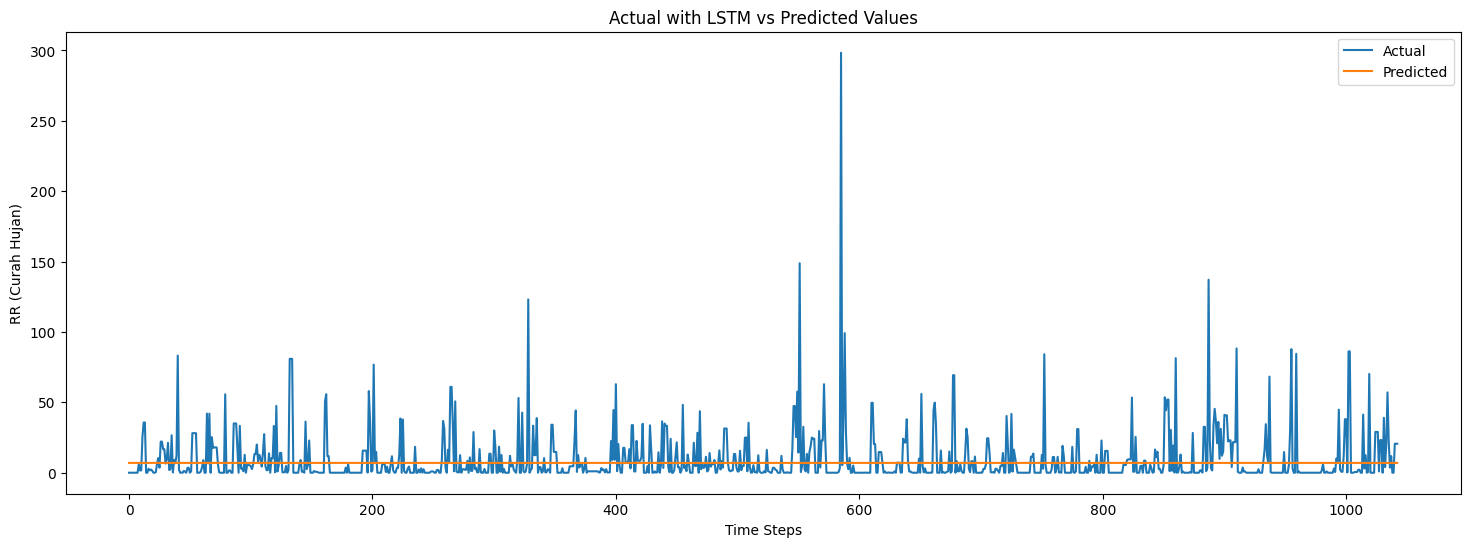

In [ ]:
# Plot prediksi vs nilai sebenarnya LSTM Reguler

# Mengembalikan ke nilai asli
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.flatten().reshape(-1, 1)).flatten()
y_test_seq = scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

plt.figure(figsize=(18, 6))
plt.plot(y_test_seq, label='Actual')
plt.plot(y_pred_lstm, label='Predicted')
plt.title('Actual with LSTM vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('RR (Curah Hujan)')
plt.legend()
plt.show()

Nilai prediksi dan nilai asli LSTM Attention

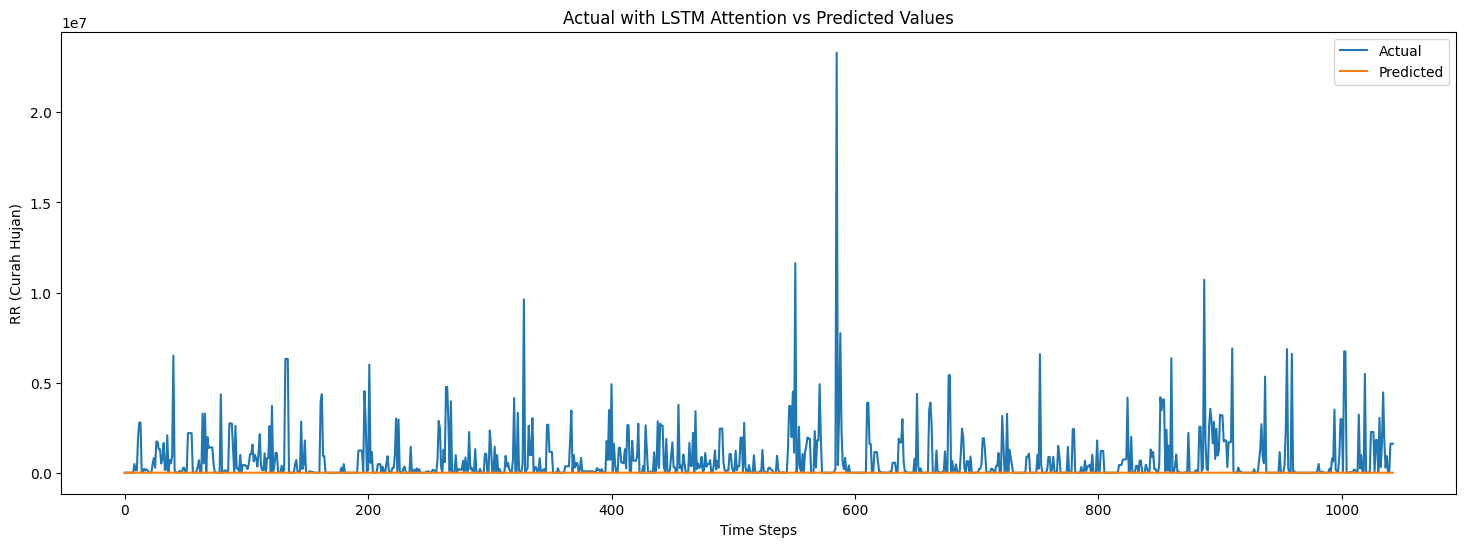

In [ ]:
# Plot prediksi vs nilai sebenarnya LSTM Attention

# Mengembalikan ke nilai asli
y_pred_lstm_attention = scaler.inverse_transform(y_pred_lstm.flatten().reshape(-1, 1)).flatten()
y_test_seq = scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

plt.figure(figsize=(18, 6))
plt.plot(y_test_seq, label='Actual')
plt.plot(y_pred_lstm_attention, label='Predicted')
plt.title('Actual with LSTM Attention vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('RR (Curah Hujan)')
plt.legend()
plt.show()

Save the model

In [ ]:
# Simpan model
tf.saved_model.save(model_lstm, 'saved_model_lstm')
tf.saved_model.save(model_lstm_attention, 'saved_model_lstm_attention')

In [ ]:
# Zip model agar mudah di download
!zip -r /content/saved_model_lstm.zip /content/saved_model_lstm
!zip -r /content/saved_model_lstm_attention.zip /content/saved_model_lstm_attention

  adding: content/saved_model_lstm/ (stored 0%)
  adding: content/saved_model_lstm/assets/ (stored 0%)
  adding: content/saved_model_lstm/variables/ (stored 0%)
  adding: content/saved_model_lstm/variables/variables.index (deflated 62%)
  adding: content/saved_model_lstm/variables/variables.data-00000-of-00001 (deflated 4%)
  adding: content/saved_model_lstm/saved_model.pb (deflated 90%)
  adding: content/saved_model_lstm/fingerprint.pb (stored 0%)
  adding: content/saved_model_lstm_attention/ (stored 0%)
  adding: content/saved_model_lstm_attention/assets/ (stored 0%)
  adding: content/saved_model_lstm_attention/variables/ (stored 0%)
  adding: content/saved_model_lstm_attention/variables/variables.index (deflated 62%)
  adding: content/saved_model_lstm_attention/variables/variables.data-00000-of-00001 (deflated 5%)
  adding: content/saved_model_lstm_attention/saved_model.pb (deflated 89%)
  adding: content/saved_model_lstm_attention/fingerprint.pb (stored 0%)
